In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dropout
from concurrent.futures import ProcessPoolExecutor
import tensorflow as tf
from tensorflow import keras
import datetime,time
import os
import random
from datetime import date

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data_online_path =r'/content/drive//MyDrive/Tmall_O2O/ccf_online_stage1_train.csv')
#data_offline_path=r'./content/drive//MyDrive/Tmall_O2O/ccf_offline_stage1_train.csv')

In [ ]:
def get_processed_data():
    dataset1 = pd.read_csv('/content/drive//MyDrive/Tmall_O2O/ProcessDataSet1.csv')
    dataset2 = pd.read_csv('/content/drive//MyDrive/Tmall_O2O/ProcessDataSet2.csv')
    dataset3 = pd.read_csv('/content/drive//MyDrive/Tmall_O2O/ProcessDataSet3.csv')
    

    dataset1.drop_duplicates(inplace=True)
    dataset2.drop_duplicates(inplace=True)
    #dataset3.drop_duplicates(inplace=True)

    dataset12 = pd.concat([dataset1, dataset2], axis=0)

    dataset12.fillna(0, inplace=True)
    dataset3.fillna(0, inplace=True)
    
    return dataset12, dataset3





if __name__ == '__main__':
    start = datetime.datetime.now()
    print(start.strftime('%Y-%m-%d %H:%M:%S'))
    # log = '%s\n' % start.strftime('%Y-%m-%d %H:%M:%S')
    cpu_jobs = os.cpu_count() - 1
    date_null = pd.to_datetime('1970-01-01', format='%Y-%m-%d')

    dataset12, dataset3 = get_processed_data()
    dataset12 = dataset12.sample(frac=1)
    
    predict_dataset = dataset3[['User_id', 'Coupon_id', 'Date_received']].copy()
    predict_dataset.Date_received = pd.to_datetime(predict_dataset.Date_received, format='%Y-%m-%d')
    predict_dataset.Date_received = predict_dataset.Date_received.dt.strftime('%Y%m%d')

    
    dataset12_feature = dataset12.drop(
        columns=['User_id', 'Merchant_id', 'Discount_rate', 'Date_received', 'discount_rate_x', 'discount_rate_y',
                 'Date', 'Coupon_id', 'label'], axis=1)
    dataset3_feature = dataset3.drop(
        columns=['User_id', 'Merchant_id', 'Discount_rate', 'Date_received', 'discount_rate_x', 'discount_rate_y',
                 'Coupon_id'], axis=1)

    
    lebel_cols = ['label_'+ str(i) for i in range(1,3)]
    label_onehot = pd.get_dummies(dataset12['label'])
    label_onehot.columns = lebel_cols
    dataset12[lebel_cols] = label_onehot
    data_label = dataset12[lebel_cols]



2022-05-11 17:20:27


In [ ]:
dataset12_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383386 entries, 115355 to 75978
Data columns (total 36 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   Distance                                   383386 non-null  int64  
 1   discount_rate                              383386 non-null  float64
 2   weekday                                    383386 non-null  int64  
 3   day                                        383386 non-null  int64  
 4   offline_user_coupon_consume                383386 non-null  float64
 5   offline_user_coupon_no_consume             383386 non-null  float64
 6   offline_user_coupon_receive                383386 non-null  float64
 7   offline_nocoupon_consume                   383386 non-null  float64
 8   total_consumptions                         383386 non-null  float64
 9   %coupon_used_in_totalconsumption           383386 non-null  float64
 10  offl

In [ ]:
    from keras import backend as K
    


    def get_compiled_model():
      model = keras.Sequential([
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
          keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(2,activation='softmax')
      ])

      model.compile(optimizer='adamax',
                loss='binary_crossentropy',
                metrics=['acc'])
      return model

    model = get_compiled_model()

    history=model.fit(dataset12_feature.values,data_label.values, epochs=800,batch_size=500)
    #adamax884422,2,92

Epoch 1/800
767/767 [==============================] - 3s 4ms/step - loss: 0.4015 - acc: 0.9158
Epoch 2/800
767/767 [==============================] - 3s 4ms/step - loss: 0.2857 - acc: 0.9169
Epoch 3/800
767/767 [==============================] - 3s 3ms/step - loss: 0.3085 - acc: 0.9170
Epoch 4/800
767/767 [==============================] - 3s 4ms/step - loss: 0.2946 - acc: 0.9175
Epoch 5/800
767/767 [==============================] - 5s 6ms/step - loss: 0.2931 - acc: 0.9178
Epoch 6/800
767/767 [==============================] - 3s 4ms/step - loss: 0.2800 - acc: 0.9177
Epoch 7/800
767/767 [==============================] - 4s 5ms/step - loss: 0.2828 - acc: 0.9176
Epoch 8/800
767/767 [==============================] - 3s 4ms/step - loss: 0.2781 - acc: 0.9177
Epoch 9/800
767/767 [==============================] - 4s 5ms/step - loss: 0.2779 - acc: 0.9177
Epoch 10/800
767/767 [==============================] - 3s 4ms/step - loss: 0.2795 - acc: 0.9176
Epoch 11/800
767/767 [=================

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve

def myauc(test):
    testgroup = test.groupby(['Coupon_id'])
    aucs = []
    for i in testgroup:
        tmpdf = i[1]
        if len(tmpdf['label'].unique()) != 2:
            continue
        fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred'], pos_label=1)
        aucs.append(auc(fpr, tpr))
    return np.average(aucs)

pred_ = model.predict(dataset12_feature)
dataset12['pred'] = pred_[:,1]
print(myauc(dataset12))

0.7588524959771744


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


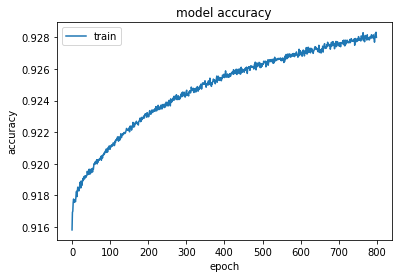

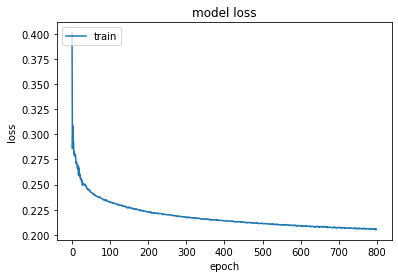

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import model_from_json

model.save_weights('model_1.h5')
model.load_weights('model_1.h5',by_name=True)

In [ ]:
model.save("/content/drive//MyDrive/Tmall_O2O/model_1.h5")

In [ ]:
predict_dataset_1 = dataset12[['User_id', 'Coupon_id', 'Date_received']].copy()

In [ ]:
pred = model.predict(dataset12_feature)
pred_test = predict_dataset_1.copy()
pred_test['Probability'] = pred[:,1]
path='/content/drive//MyDrive/Tmall_O2O//'
pred_test.to_csv(os.path.join(path,'submit_1.csv'), index=False, header=True)
pred_test.describe()

,User_id,Coupon_id,Probability
count,3.833860e+05,383386.000000,383386.000000
mean,3.683603e+06,6287.911630,0.041546
std,2.123219e+06,3938.971496,0.134257
min,4.000000e+00,1.000000,0.000000
25%,1.843305e+06,2418.000000,0.000139
50%,3.685242e+06,5584.000000,0.001736
75%,5.522414e+06,9566.000000,0.016856
max,7.360961e+06,14045.000000,1.000000


In [ ]:
pred = model.predict(dataset3_feature)
pred_test = predict_dataset.copy()
pred_test['Probability'] = pred[:,1]
path='/content/drive//MyDrive/Tmall_O2O//'
pred_test.to_csv(os.path.join(path,'submit_final.csv'), index=False, header=True)
pred_test.describe()

,User_id,Coupon_id,Probability
count,1.136400e+05,113640.000000,113640.000000
mean,3.684858e+06,9053.810929,0.122335
std,2.126259e+06,4145.873088,0.233893
min,2.090000e+02,3.000000,0.000000
25%,1.844191e+06,5023.000000,0.001074
50%,3.683266e+06,9983.000000,0.011772
75%,5.525845e+06,13602.000000,0.117454
max,7.361024e+06,14045.000000,1.000000
